# Contaminant Clustering

## Simple Clustering

In [1]:
import datetime
import math
from itertools import product

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for inline plots in jupyter
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from popsborder.consignments import Box, Consignment
from popsborder.inputs import load_configuration_yaml_from_text
from popsborder.contamination import add_contaminant_clusters
from popsborder.outputs import pretty_consignment

In [3]:
def plot_binned_distribution(
    ax,
    all_values,
    num_consignments,
    clustering,
    contamination_rate,
    num_bins=20,
    palette="viridis",
):
    """
    Plots a binned bar chart of contaminated items over consignments.

    Parameters:
        all_values (np.ndarray): Array of values representing contaminated items.
        num_consignments (int): Number of consignments.
        clustering: Clustering number
        contamination_rate: Contamination rate
        num_bins (int): Number of bins to use for aggregation (default: 20).
        palette (str): Seaborn color palette for the bars (default: "viridis").
    """
    x = np.arange(len(all_values))
    num_bins = min(num_bins, len(x))
    bins = np.linspace(x.min(), x.max(), num_bins + 1)
    # Assign each x to a bin.
    bin_indices = np.digitize(x, bins)

    # Accumulate the y-values for each bin.
    binned_values = np.zeros(num_bins)
    x_labels = []
    for i in range(1, num_bins + 1):
        # Find the original x values in this bin.
        x_in_bin = x[bin_indices == i]
        # Sum y-values in each bin.
        binned_values[i - 1] = all_values[bin_indices == i].sum()
        # Use the first x value for labeling.
        x_labels.append(x_in_bin[0] if len(x_in_bin) > 0 else None)

    # Filter out empty bins if necessary.
    valid_indices = [i for i, label in enumerate(x_labels) if label is not None]
    x_labels = [f"{x_labels[i]}" for i in valid_indices]
    binned_values = np.array([binned_values[i] for i in valid_indices])

    # Plot
    fontsize = 7
    sns.barplot(ax=ax, x=x_labels, y=binned_values, hue=x_labels, legend=False, palette=palette)
    ax.set_title(
        f"Distribution of contaminated items over {num_consignments} consignments\n"
        f" clustering: {clustering},"
        f" contamination rate: {contamination_rate}",
        fontsize=fontsize,
    )
    ax.set_xlabel(
        f"Position in a consignment (divided into {num_bins} bins for plotting)",
        fontsize=fontsize,
    )
    ax.set_ylabel("Number of shipments with a contaminated item", fontsize=fontsize)
    # Set the rotation for x-axis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)

In [4]:
def get_consignment(num_items):
    """Get basic consignment with given number of items all in one box"""
    items = np.zeros(num_items, dtype=int)
    return Consignment(
        flower="Rosa",
        date=datetime.date(2018, 2, 15),
        origin="Mexico",
        port="FL Miami Air CBP",
        num_items=num_items,
        items=items,
        num_boxes=1,
        boxes=[Box(items)],
        items_per_box=num_items,
        pathway="air",
    )

In [5]:
config_yaml = """
contamination:
    contamination_rate:
        distribution: fixed_value
        value: {contamination_rate}
    contamination_unit: item
    arrangement: clustered
    clustered:
        distribution: subset
        clustering: {clustering}
"""

In [6]:
def simulate(config, ax, num_items, num_consignments):
    contamination_rate = config["contamination_rate"]["value"]
    all_values = np.zeros(num_items)
    for i in range(num_consignments):
        consignment = get_consignment(num_items)
        add_contaminant_clusters(config, consignment)
        contaminated_items = int(num_items * contamination_rate)
        assert np.count_nonzero(consignment.items) == contaminated_items
        all_values += consignment.items
    plot_binned_distribution(
        ax,
        all_values,
        num_consignments=num_consignments,
        contamination_rate=contamination_rate,
        clustering=config["clustered"]["clustering"],
    )

In [7]:
def explore(config_yaml, rates, clusterings, num_items, num_consignments):
    num_rows = len(rates)
    num_cols = len(clusterings)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)

    for (i, rate), (j, clustering) in product(enumerate(rates), enumerate(clusterings)):
        ax = axes[i, j]
        config = load_configuration_yaml_from_text(
            config_yaml.format(
                contamination_rate=rate,
                clustering=clustering,
                )
        )["contamination"]
        simulate(config, ax, num_items=num_items, num_consignments=num_consignments)
    plt.tight_layout()
    plt.show()

### Cluster Formation

This shows how a cluster looks like in one consignment. We expect to see see a cluster for higher clusterings.

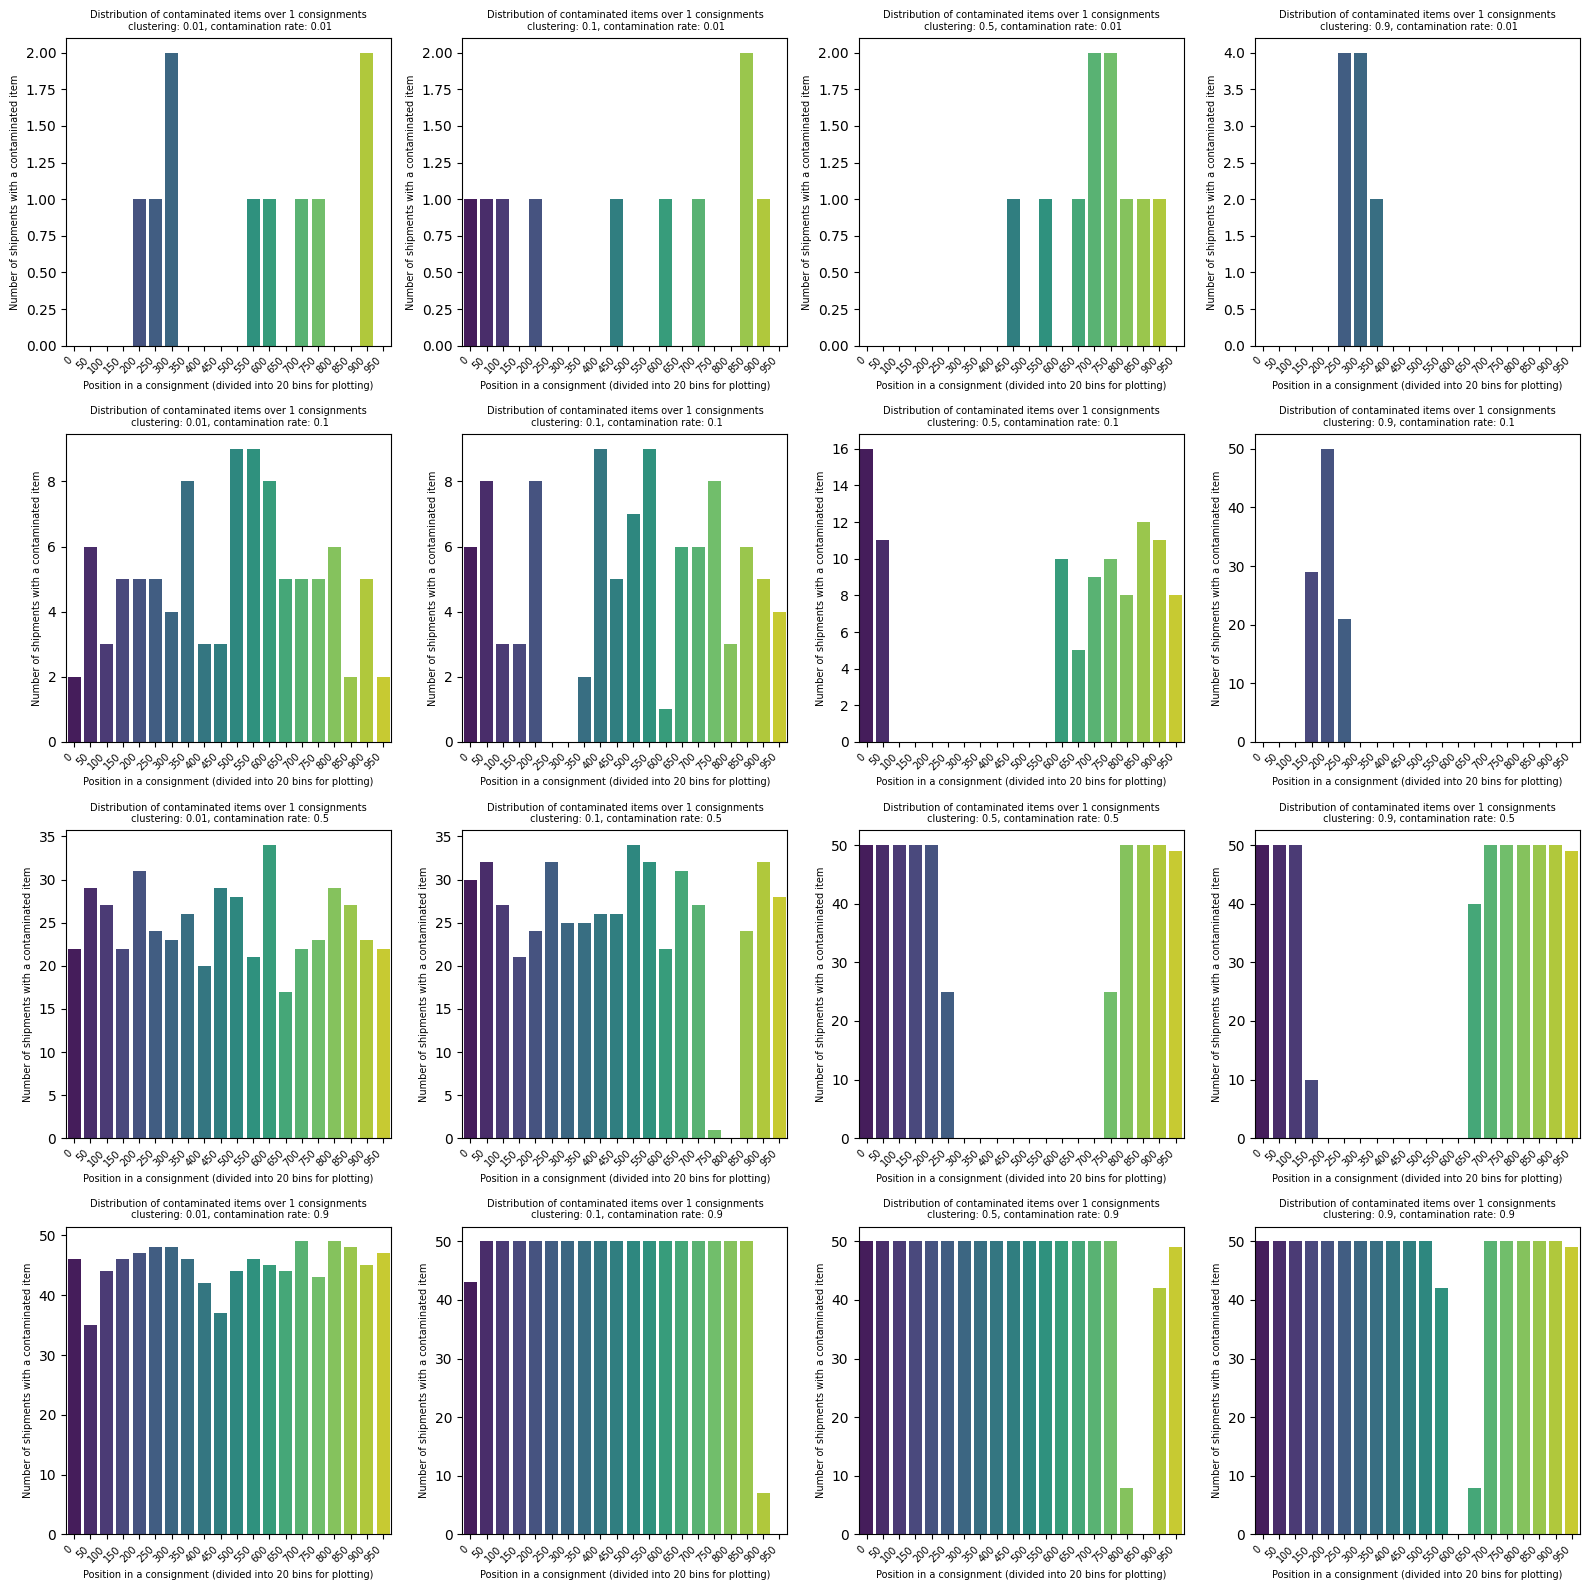

In [8]:
explore(
    config_yaml,
    rates=[0.01, 0.1, 0.5, 0.9],
    clusterings=[0.01, 0.1, 0.5, 0.9],
    num_items=1000,
    num_consignments=1
)

### Contaminated Item Distribution

This shows how contaminated items are distributed on average. We expect a uniform distribution because clustering should not influence contaminated item distribution across many consignments.

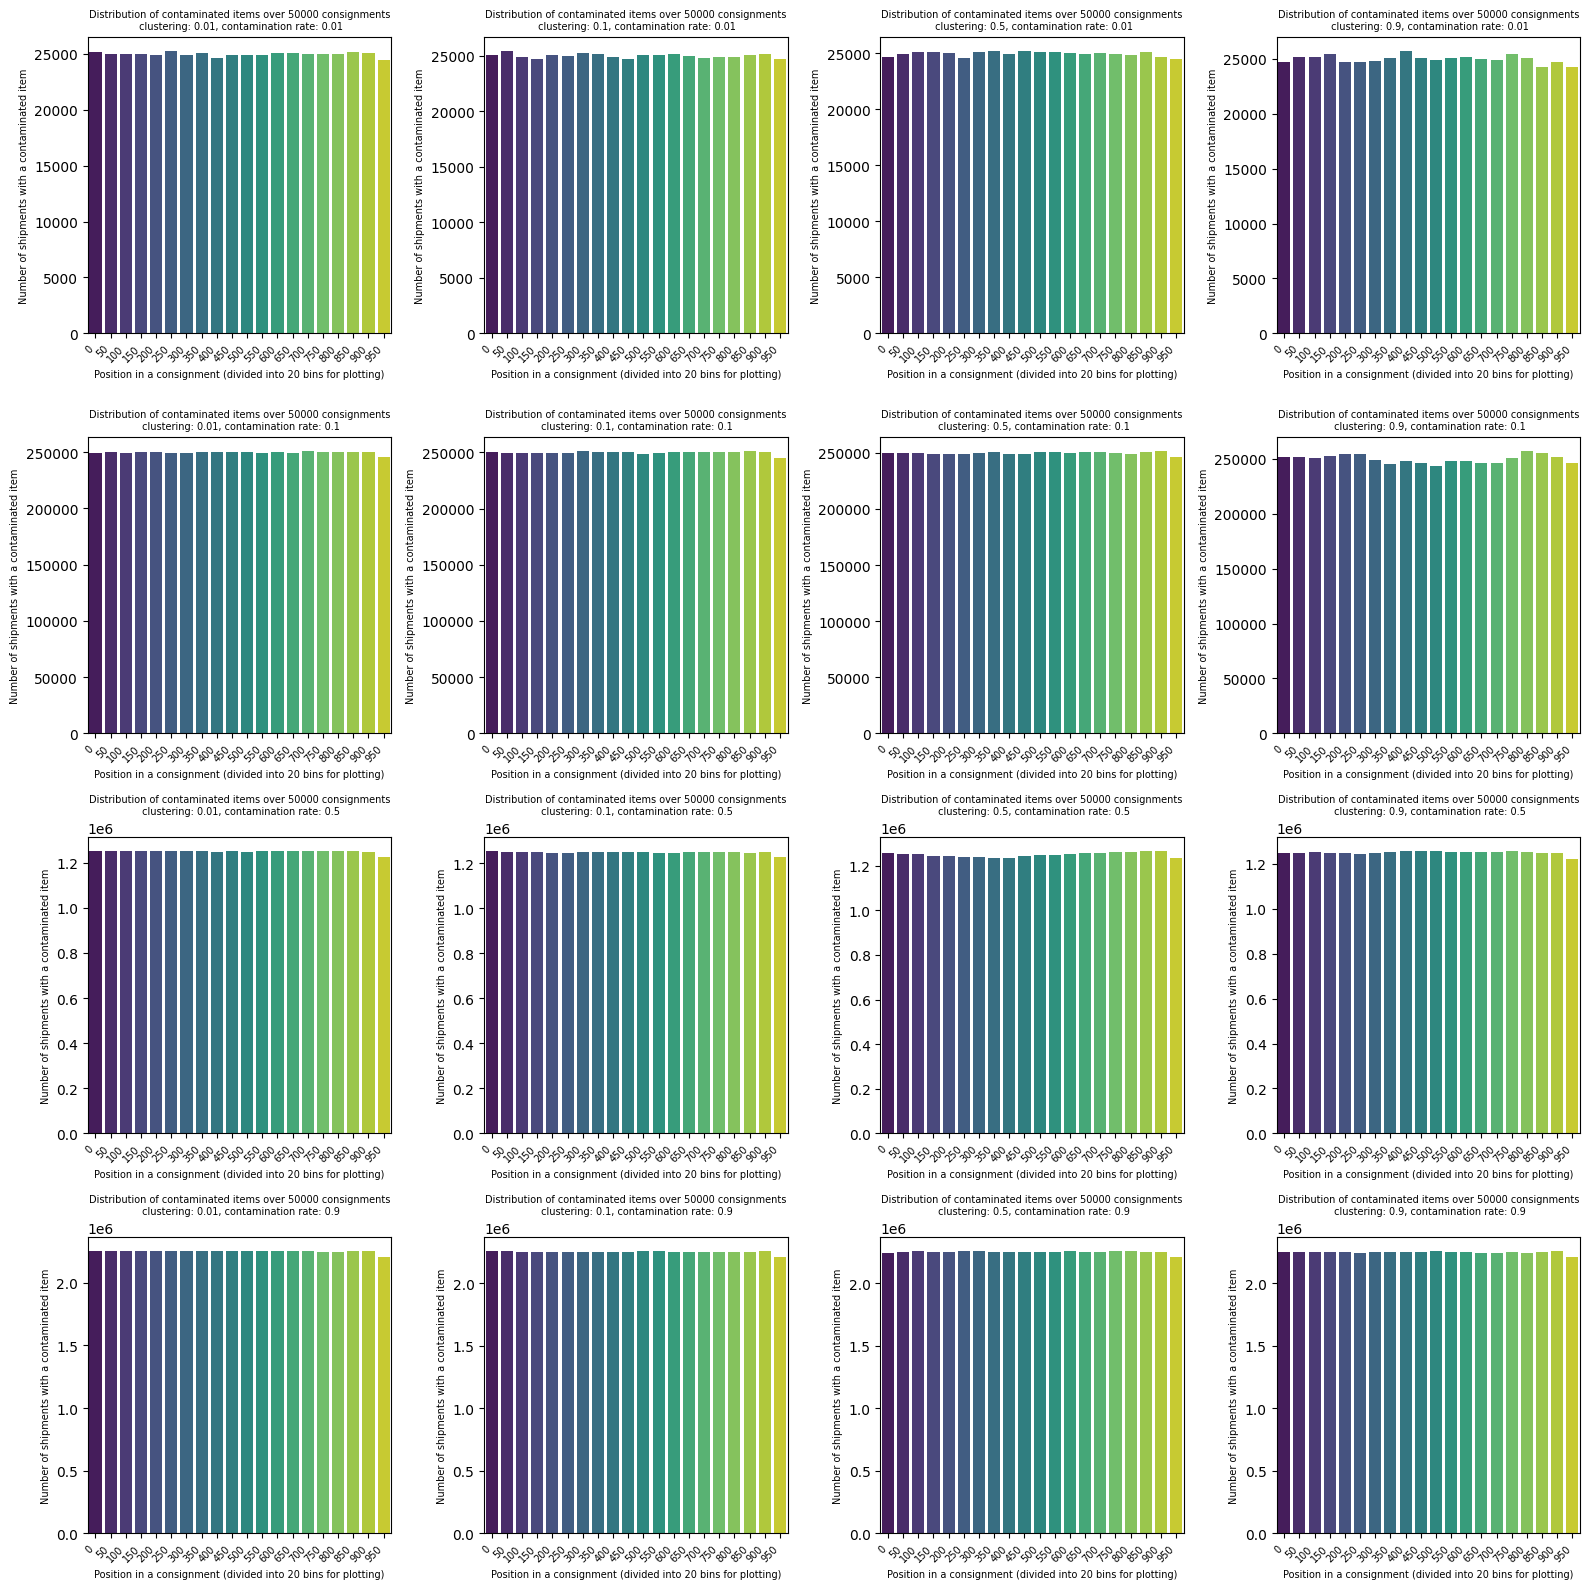

In [9]:
explore(
    config_yaml,
    rates=[0.01, 0.1, 0.5, 0.9],
    clusterings=[0.01, 0.1, 0.5, 0.9],
    num_items=1000,
    num_consignments=50000
)

## Exploring Distributions

In [10]:
# import seaborn
import seaborn as sns

# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={"figure.figsize": (5, 5)})

In [11]:
from scipy.stats import beta

infest_beta = beta.rvs(4, 60, size=10000)

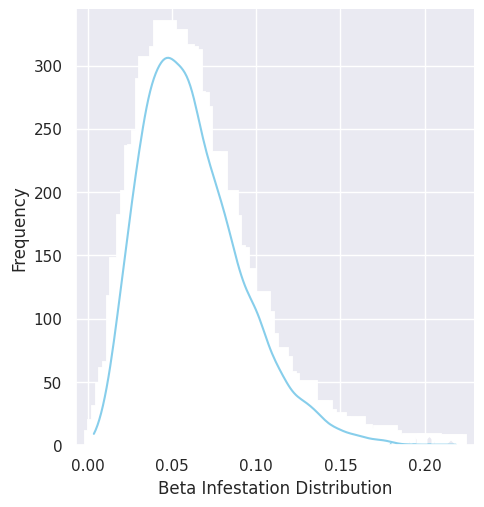

In [12]:
ax = sns.displot(
    infest_beta, kde=True, bins=100, color="skyblue", linewidth=15, alpha=1
)
ax.set(xlabel="Beta Infestation Distribution", ylabel="Frequency")

In [13]:
# Choose infestation rate for shipment from beta distribution
infest_rate = beta.rvs(4, 60, size=1)[0]
print("Infestation rate:", round(infest_rate, 4))

Infestation rate: 0.1326


In [14]:
num_stem = np.random.randint(1, high=1000000, size=1)[0]  # QUANTITY

# Calculate number of pests in shipment based on infestation rate.
num_pest = int(num_stem * infest_rate)
print("Num stems: ", int(num_stem))
print("Num pests:", num_pest)
np.arange(num_stem)

Num stems:  942250
Num pests: 124940


array([     0,      1,      2, ..., 942247, 942248, 942249],
      shape=(942250,))

In [15]:
# Infest stems using uniform distribution
infest_stem_unif = np.random.choice(int(num_stem), num_pest, replace=False)

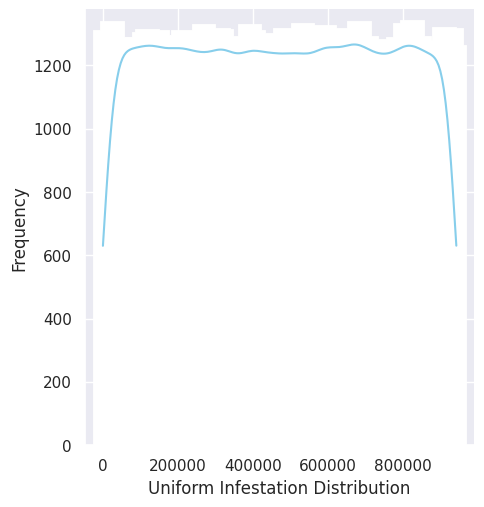

In [16]:
ax = sns.displot(
    infest_stem_unif, kde=True, bins=100, color="skyblue", linewidth=15, alpha=1
)
ax.set(xlabel="Uniform Infestation Distribution", ylabel="Frequency")

In [17]:
from scipy.stats import gamma

# Infest stems using gamma distribution to create cluster of pests.
infest_clust = gamma.rvs(
    3, scale=500, size=40000
)  # rvs(a, loc=0, scale=1, size=1, random_state=None)
infest_clust = [round(x) for x in infest_clust]

# Insert infested cluster of stems into shipment at random position
start_clust = np.random.randint(1, high=num_stem - max(infest_clust), size=1)
infest_stem_clust = infest_clust + start_clust

print("Size of cluster:", int(max(infest_stem_clust) - min(infest_stem_clust)), "stems")

Size of cluster: 8409 stems


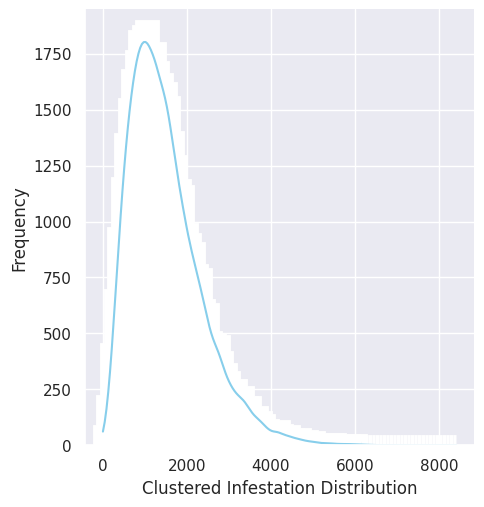

In [18]:
ax = sns.displot(
    infest_clust, kde=True, bins=100, color="skyblue", linewidth=15, alpha=1
)
ax.set(xlabel="Clustered Infestation Distribution", ylabel="Frequency")

In [19]:
num_boxes = math.ceil(num_stem / 200)
print(num_boxes)

4712
